## DATA

In [ ]:
import json
import os
import csv
import numpy as np
from numpy import mean
import pandas as pd
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from keras.layers import Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import GRU
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from tensorflow.keras import layers
from tensorflow import keras


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = r"/content/drive/MyDrive/ALCOA/alcoa"

data = {}
recipes = {}

with open(r"/content/drive/MyDrive/ALCOA/DATA-5.2-I1000_new.tsv") as csvfile:
    reader = csv.reader(csvfile, delimiter='\t')
    for r in reader:
        s = str(r[0]).zfill(6)
        if s not in data.keys():
            if r[1] not in recipes.keys() and r[1] != "RECIPE_ID":
                recipes[r[1]] = None
            data[s] = {}
            data[s]["sensors"] = {}
            data[s]["alcoa"] = {}
            data[s]["recipe"] = r[1]
        if r[3] not in data [s]["sensors"].keys() and r[3] != "TAGNAME":
            data[s]["sensors"][r[3]] = {}
            data[s]["sensors"][r[3]]["val"] = []
            data[s]["sensors"][r[3]]["time"] = []
        if r[3] != "TAGNAME":    
            data[s]["sensors"][r[3]]["val"].append(r[4])
            data[s]["sensors"][r[3]]["time"].append(float(r[5]))

        
for batch_id in data.keys():   
    
    if batch_id == "ORDER_ID":
        continue
    try:
        f = open(os.path.join(folder,str(batch_id) + '_rev1_alcoa_output.json'))
        json_data = json.load(f)
        f.close()
        for key in json_data['alcoa'].keys():
            if key == 'date':
                continue
            data[batch_id]["alcoa"][key] = json_data['alcoa'][key]['score']
    except: 
        data[batch_id] = None;
        
del data["ORDER_ID"]

a = []        
for batch_id in data.keys():
    if data[batch_id] == None:
        a.append(batch_id)
        continue
    data[batch_id]["alcoa"] = list(data[batch_id]["alcoa"].values())

def match_alcoa_after_N_batches(data):
    max_times = {}
    ret_vect = {}
    for batch_id in data.keys():   
        d = data[batch_id]

        if d == None:
            continue;
        data[batch_id]["max_time"] = 0

        for sensor_id in d['sensors'].keys():
            m = max(d['sensors'][sensor_id]['time'])
            if m > data[batch_id]["max_time"]:
                data[batch_id]["max_time"] = m
        max_times[batch_id] = data[batch_id]["max_time"]
    max_times = {k: v for k, v in sorted(max_times.items(), key=lambda item: item[1])}
    keys = list(max_times.keys())
   
    return keys

one_hot_encodings = {}
i = 0;
for recipe in recipes.keys():
    one_hot_encodings[recipe] = []
    for h in range(len(recipes)):
        if(h==i):
            one_hot_encodings[recipe].append(1)
        else:
            one_hot_encodings[recipe].append(0)
    i+=1

k = match_alcoa_after_N_batches(data)

In [ ]:
data.keys()

dict_keys(['031016', '031019', '031018', '932386', '932786', '931713', '031034', '932155', '931291', '031029', '931973', '931527', '833337', '931708', '931532', '932689', '931009', '932391', '932791', '932690', '931010', '031022', '932138', '932151', '931805', '932794', '933361', '031026', '932134', '933360', '931006', '932382', '931970', '932129', '932800', '932389', '931710', '933116', '932152', '932398', '932383', '932168', '932795', '931005', '031030', '932801', '931701', '932688', '931292', '932686', '931528', '932387', '031035', '932390', '932790', '031021', '932684', '931290', '932799', '931702', '932375', '031028', '932797', '933264', '931533', '833334', '932144', '932822', '031025', '933254', '931003', '931526', '932787', '931712', '932154', '931287', '932785', '931700', '932139', '931289', '932142', '932381', '931803', '931294', '931964', '932805', '031037', '932147', '933261', '031039', '932132', '932135', '931966', '931705', '932150', '931974', '931007', '933114', '932803',

In [ ]:
data['031016']["alcoa"][4]

39

In [ ]:
data["031016"]["recipe"]

'155696'

In [ ]:
recipes.keys()

dict_keys(['155696', '153720', '155610', '154928'])

In [ ]:
one_hot_encodings[data["031016"]["recipe"]]

[1, 0, 0, 0]

In [ ]:
one_hot_encodings.keys()

dict_keys(['155696', '153720', '155610', '154928'])

In [ ]:
for batch_id in data.keys():
  if data[batch_id]==None:
    print(batch_id)
del data["932147"]   
del data["031023"]   
del data["933256"]

932147
031023
933256


In [ ]:
yAttributable= []
yLegible = []
yContemporaneous= []
yOriginal = []
yAccurate= []
yComplete = []
yConsistent = []
yAvailable = []
yEnduring = []

for batch_id in data.keys():
    yAttributable.append(data[batch_id]["alcoa"][0])
yAttributable = tf.convert_to_tensor(yAttributable, dtype=tf.float32)
yAttributable = yAttributable.numpy()

for batch_id in data.keys():
    yLegible.append(data[batch_id]["alcoa"][1])
yLegible = tf.convert_to_tensor(yLegible, dtype=tf.float32)
yLegible = yLegible.numpy()
    
for batch_id in data.keys():
    yContemporaneous.append(data[batch_id]["alcoa"][2])
yContemporaneous = tf.convert_to_tensor(yContemporaneous, dtype=tf.float32)
yContemporaneous = yContemporaneous.numpy()    

for batch_id in data.keys():
    yOriginal.append(data[batch_id]["alcoa"][3])
yOriginal = tf.convert_to_tensor(yOriginal, dtype=tf.float32)
yOriginal = yOriginal.numpy()    

for batch_id in data.keys():
    yAccurate.append(data[batch_id]["alcoa"][4]) 
yAccurate = tf.convert_to_tensor(yAccurate, dtype=tf.float32)
yAccurate = yAccurate.numpy()    

for batch_id in data.keys():
    yComplete.append(data[batch_id]["alcoa"][5]) 
yComplete = tf.convert_to_tensor(yComplete, dtype=tf.float32)
yComplete = yComplete.numpy()  

for batch_id in data.keys():
    yConsistent.append(data[batch_id]["alcoa"][6]) 
yConsistent = tf.convert_to_tensor(yConsistent, dtype=tf.float32)
yConsistent = yConsistent.numpy()    

for batch_id in data.keys():
    yAvailable.append(data[batch_id]["alcoa"][7]) 
yAvailable = tf.convert_to_tensor(yAvailable, dtype=tf.float32)
yAvailable = yAvailable.numpy()

for batch_id in data.keys():
    yEnduring.append(data[batch_id]["alcoa"][8]) 
yEnduring = tf.convert_to_tensor(yEnduring, dtype=tf.float32)
yEnduring = yEnduring.numpy()    

print(len(yAttributable))
print(yAccurate)

176
[39. 32. 36. 38. 34. 25. 38. 36. 40. 39. 39. 37. 30. 39. 40. 40. 40. 36.
 39. 36. 41. 33. 39. 38. 38. 35. 36. 38. 34. 36. 50. 37. 39. 34. 36. 36.
 36. 38. 42. 38. 40. 39. 35. 50. 35. 50. 40. 36. 38.  0. 36. 36. 38. 36.
 42. 38. 39. 36. 35. 36. 35. 39. 35. 35. 39. 38. 38. 36. 42. 34. 50. 38.
 36. 33. 36. 33. 40. 38.  0. 37. 32. 38. 36. 36. 36. 37. 38. 35. 36. 38.
 36. 34. 35. 38. 39. 50. 40. 38. 38. 36. 36. 38. 36. 39. 50. 38. 37. 50.
 36. 36. 40. 38. 36. 36. 36. 50. 33. 35. 34. 40. 37. 39. 50. 42. 36. 34.
 35. 38. 38. 39. 38.  0. 38. 35. 39. 38. 41. 38. 33. 35. 35. 36. 38. 36.
 36. 40. 36. 35. 38. 39. 38. 36. 33. 50. 41. 36. 39. 37. 40. 38. 36. 38.
 50. 33. 36. 36. 30. 38. 37. 36. 36. 50. 38. 50. 37. 36.]


In [ ]:
a= []
b= []
c= []
d = []
e = []
p = []

for batch_id in data.keys():
  p = one_hot_encodings[data[batch_id]["recipe"]]
  a.append(p)
a = tf.convert_to_tensor(a, dtype=tf.float32) 
a = a.numpy()   

for i in range (len(a)):
  p = a[i,0] 
  b.append(p)

for i in range (len(a)):
  p = a[i,1]
  c.append(p)

for i in range (len(a)):
  p = a[i,2] 
  d.append(p)
  
for i in range (len(a)):
  p = a[i,3] 
  e.append(p)

In [ ]:
print(len(d))

176


In [ ]:
import pandas as pd
df = [b,c,d,e ,yLegible, yAttributable, yContemporaneous, yOriginal, yAccurate, yComplete, yConsistent, yAvailable, yEnduring]
df = pd.DataFrame(df)

In [ ]:
df = df.T

In [ ]:
df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1.0,0.0,0.0,0.0,81.0,48.0,85.0,100.0,39.0,97.0,100.0,0.0,0.0
1,1.0,0.0,0.0,0.0,81.0,49.0,88.0,100.0,32.0,97.0,100.0,0.0,0.0
2,1.0,0.0,0.0,0.0,77.0,50.0,92.0,100.0,36.0,98.0,100.0,0.0,0.0
3,0.0,1.0,0.0,0.0,86.0,49.0,88.0,100.0,38.0,98.0,100.0,0.0,0.0
4,1.0,0.0,0.0,0.0,80.0,49.0,90.0,100.0,34.0,98.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.0,1.0,0.0,0.0,90.0,50.0,71.0,100.0,50.0,90.0,100.0,0.0,0.0
172,1.0,0.0,0.0,0.0,78.0,50.0,93.0,100.0,38.0,98.0,100.0,0.0,0.0
173,1.0,0.0,0.0,0.0,90.0,50.0,62.0,100.0,50.0,84.0,100.0,0.0,0.0
174,0.0,1.0,0.0,0.0,84.0,49.0,92.0,100.0,37.0,98.0,100.0,0.0,0.0


In [ ]:
df.columns = ['0','1', '2', '3' ,'Legible' , 'Attributable', 'Contemporaneous', 'Original', 'Accurate', 'Complete', 'Consistent', 'Available', 'Enduring']

In [ ]:
df

,0,1,2,3,Legible,Attributable,Contemporaneous,Original,Accurate,Complete,Consistent,Available,Enduring
0,1.0,0.0,0.0,0.0,81.0,48.0,85.0,100.0,39.0,97.0,100.0,0.0,0.0
1,1.0,0.0,0.0,0.0,81.0,49.0,88.0,100.0,32.0,97.0,100.0,0.0,0.0
2,1.0,0.0,0.0,0.0,77.0,50.0,92.0,100.0,36.0,98.0,100.0,0.0,0.0
3,0.0,1.0,0.0,0.0,86.0,49.0,88.0,100.0,38.0,98.0,100.0,0.0,0.0
4,1.0,0.0,0.0,0.0,80.0,49.0,90.0,100.0,34.0,98.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.0,1.0,0.0,0.0,90.0,50.0,71.0,100.0,50.0,90.0,100.0,0.0,0.0
172,1.0,0.0,0.0,0.0,78.0,50.0,93.0,100.0,38.0,98.0,100.0,0.0,0.0
173,1.0,0.0,0.0,0.0,90.0,50.0,62.0,100.0,50.0,84.0,100.0,0.0,0.0
174,0.0,1.0,0.0,0.0,84.0,49.0,92.0,100.0,37.0,98.0,100.0,0.0,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   0                176 non-null    float32
 1   1                176 non-null    float32
 2   2                176 non-null    float32
 3   3                176 non-null    float32
 4   Legible          176 non-null    float32
 5   Attributable     176 non-null    float32
 6   Contemporaneous  176 non-null    float32
 7   Original         176 non-null    float32
 8   Accurate         176 non-null    float32
 9   Complete         176 non-null    float32
 10  Consistent       176 non-null    float32
 11  Available        176 non-null    float32
 12  Enduring         176 non-null    float32
dtypes: float32(13)
memory usage: 9.1 KB


In [ ]:
df.describe()

,0,1,2,3,Legible,Attributable,Contemporaneous,Original,Accurate,Complete,Consistent,Available,Enduring
count,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.000000,176.0,176.000000,176.000000,176.0,176.0,176.0
mean,0.505682,0.482955,0.005682,0.005682,83.102272,48.170456,87.647728,100.0,37.221592,96.761360,100.0,0.0,0.0
std,0.501394,0.501135,0.075378,0.075378,4.000112,2.139275,6.316491,0.0,6.427777,2.846529,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,75.000000,25.000000,62.000000,100.0,0.000000,84.000000,100.0,0.0,0.0
25%,0.000000,0.000000,0.000000,0.000000,80.000000,48.000000,86.000000,100.0,36.000000,97.000000,100.0,0.0,0.0
50%,1.000000,0.000000,0.000000,0.000000,84.000000,48.000000,89.000000,100.0,37.000000,98.000000,100.0,0.0,0.0
75%,1.000000,1.000000,0.000000,0.000000,86.000000,49.000000,91.000000,100.0,39.000000,98.000000,100.0,0.0,0.0
max,1.000000,1.000000,1.000000,1.000000,94.000000,50.000000,95.000000,100.0,50.000000,98.000000,100.0,0.0,0.0


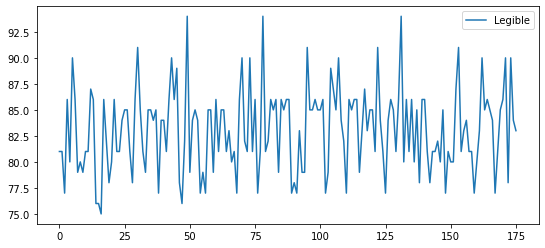

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
df['Legible'].plot(ax=ax, label='Legible')
ax.legend();

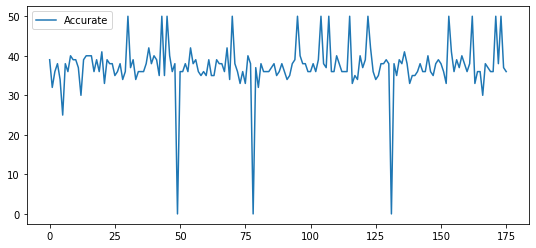

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
df['Accurate'].plot(ax=ax, label='Accurate')
ax.legend();

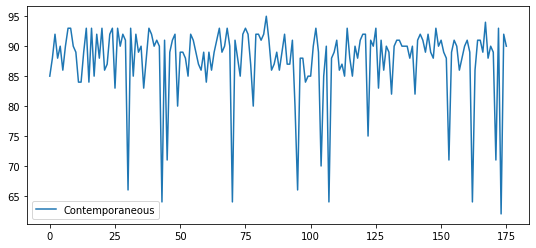

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
df['Contemporaneous'].plot(ax=ax, label='Contemporaneous')
ax.legend();

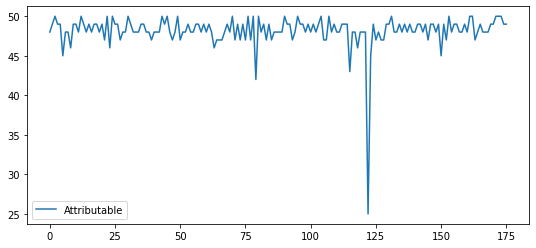

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
df['Attributable'].plot(ax=ax, label='Attributable')
ax.legend();

## ACCURATE

In [ ]:
steps = 30
data_train = df[:-steps]
data_test  = df[-steps:]

In [ ]:
data_train

,0,1,2,3,Legible,Attributable,Contemporaneous,Original,Accurate,Complete,Consistent,Available,Enduring
0,1.0,0.0,0.0,0.0,81.0,48.0,85.0,100.0,39.0,97.0,100.0,0.0,0.0
1,1.0,0.0,0.0,0.0,81.0,49.0,88.0,100.0,32.0,97.0,100.0,0.0,0.0
2,1.0,0.0,0.0,0.0,77.0,50.0,92.0,100.0,36.0,98.0,100.0,0.0,0.0
3,0.0,1.0,0.0,0.0,86.0,49.0,88.0,100.0,38.0,98.0,100.0,0.0,0.0
4,1.0,0.0,0.0,0.0,80.0,49.0,90.0,100.0,34.0,98.0,100.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
141,1.0,0.0,0.0,0.0,81.0,49.0,91.0,100.0,36.0,98.0,100.0,0.0,0.0
142,1.0,0.0,0.0,0.0,78.0,49.0,92.0,100.0,38.0,98.0,100.0,0.0,0.0
143,1.0,0.0,0.0,0.0,81.0,48.0,91.0,100.0,36.0,98.0,100.0,0.0,0.0
144,1.0,0.0,0.0,0.0,81.0,49.0,89.0,100.0,36.0,97.0,100.0,0.0,0.0


In [ ]:

!pip install skforecast

     |████████████████████████████████| 87 kB 5.7 MB/s 
     |████████████████████████████████| 76 kB 5.2 MB/s 
     |████████████████████████████████| 9.8 MB 52.1 MB/s 
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.64.0
    Uninstalling tqdm-4.64.0:
      Successfully uninstalled tqdm-4.64.0
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregMultiOutput import ForecasterAutoregMultiOutput
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from joblib import dump, load

In [ ]:
# Create and train forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 30
                )

forecaster.fit(y=data_train['Accurate'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30] 
Window size: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 145] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
Creation date: 2022-04-27 13:20:47 
Last fit date: 2022-04-27 13:20:47 
Skforecast version: 0.4.3 

In [ ]:
steps = 30
predictions = forecaster.predict(steps=steps)
predictions.head(20)

146    31.75
147    34.49
148    39.91
149    40.14
150    38.62
151    36.89
152    39.02
153    35.08
154    37.03
155    36.36
156    38.16
157    39.79
158    37.20
159    37.73
160    33.88
161    36.78
162    36.74
163    37.72
164    37.31
165    36.72
Name: pred, dtype: float64

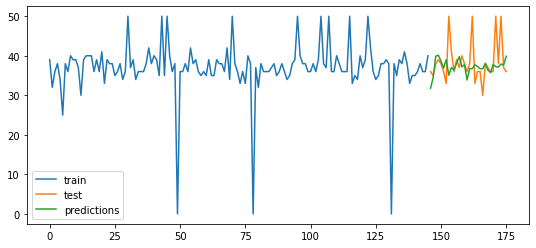

In [ ]:
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Accurate'].plot(ax=ax, label='train')
data_test['Accurate'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
error_mse = mean_squared_error(
                y_true = data_test['Accurate'],
                y_pred = predictions
            )

print(f"Test error (mse): {error_mse}")

Test error (mse): 29.836989999999993


In [ ]:
steps = 30
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # This value will be replaced in the grid search
             )

# Lags used as predictors
lags_grid = [10, 20]

# Regressor's hyperparameters
param_grid = {'n_estimators': [100, 500],
              'max_depth': [3, 5, 10]}

results_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = data_train['Accurate'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = True,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        verbose            = False
               )

Number of models compared: 12


loop lags_grid: 100%|███████████████████████████████████████| 2/2 [00:38<00:00, 19.36s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10] 
  Parameters: {'max_depth': 3, 'n_estimators': 100}
  Backtesting metric: 56.89662996500172



In [ ]:
results_grid

,lags,params,metric,max_depth,n_estimators
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 100}",56.896630,3,100
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 3, 'n_estimators': 500}",57.635186,3,500
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",57.685328,10,500
7,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",58.158686,3,500
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",58.190518,5,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 500}",58.258891,5,500
6,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",58.372786,3,100
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 5, 'n_estimators': 100}",58.454384,5,100
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 100}",58.795624,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","{'max_depth': 10, 'n_estimators': 500}",58.826444,10,500


In [ ]:
# Create and train forecaster with the best hyperparameters
# ==============================================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=100, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 10
             )

forecaster.fit(y=data_train['Accurate'])

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict(steps=steps)

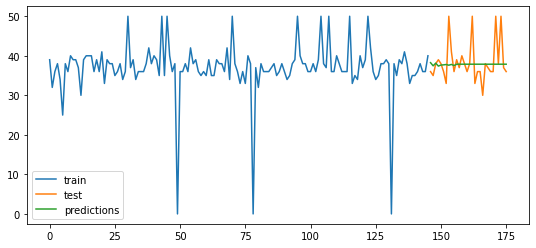

In [ ]:
# Plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Accurate'].plot(ax=ax, label='train')
data_test['Accurate'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Lasso(random_state=123)),
                    steps     = 30,
                    lags      = 8
             )

forecaster

ForecasterAutoregMultiOutput 
Regressor: Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lasso', Lasso(random_state=123))]) 
Lags: [1 2 3 4 5 6 7 8] 
Window size: 8 
Maximum steps predicted: 30 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'standardscaler__copy': True, 'standardscaler__with_mean': True, 'standardscaler__with_std': True, 'lasso__alpha': 1.0, 'lasso__copy_X': True, 'lasso__fit_intercept': True, 'lasso__max_iter': 1000, 'lasso__normalize': 'deprecated', 'lasso__positive': False, 'lasso__precompute': False, 'lasso__random_state': 123, 'lasso__selection': 'cyclic', 'lasso__tol': 0.0001, 'lasso__warm_start': False} 
Creation date: 2022-04-27 13:10:42 
Last fit date: None 
Skforecast version: 0.4.3 

In [ ]:
# Hyperparameter Grid search
# ==============================================================================
forecaster = ForecasterAutoregMultiOutput(
                    regressor = make_pipeline(StandardScaler(), Lasso(random_state=123)),
                    steps     = 30,
                    lags      = 8 # This value will be replaced in the grid search
             )

# To access parameters of a scikitlearn pipeline the pattern:
# <name of the step>__<name of the parameter>.
param_grid = {'lasso__alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

results_grid = grid_search_forecaster(
                        forecaster  = forecaster,
                        y           = data_train['Accurate'],
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = 30,
                        refit       = True,
                        metric      = 'mean_squared_error',
                        initial_train_size = int(len(data_train)*0.5),
                        fixed_train_size   = False,
                        return_best = True,
                        verbose     = False
                )

Number of models compared: 30


loop lags_grid: 100%|███████████████████████████████████████| 3/3 [00:11<00:00,  3.84s/it]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [1 2 3 4 5] 
  Parameters: {'lasso__alpha': 46.41588833612782}
  Backtesting metric: 54.23711373630963



In [ ]:
results_grid.head()

,lags,params,metric,lasso__alpha
6,"[1, 2, 3, 4, 5]",{'lasso__alpha': 46.41588833612782},54.237114,46.415888
7,"[1, 2, 3, 4, 5]",{'lasso__alpha': 599.4842503189421},54.237114,599.484250
8,"[1, 2, 3, 4, 5]",{'lasso__alpha': 7742.636826811277},54.237114,7742.636827
9,"[1, 2, 3, 4, 5]",{'lasso__alpha': 100000.0},54.237114,100000.000000
5,"[1, 2, 3, 4, 5]",{'lasso__alpha': 3.593813663804626},54.241741,3.593814


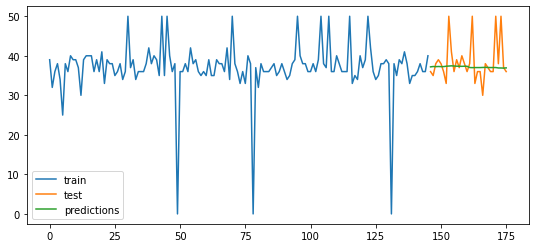

In [ ]:
# Predictions
# ==============================================================================
predictions = forecaster.predict()

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
data_train['Accurate'].plot(ax=ax, label='train')
data_test['Accurate'].plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [ ]:
# Test error
# ==============================================================================
error_mse = mean_squared_error(y_true = data_test['Accurate'], y_pred = predictions)
print(f"Test error (mse) {error_mse}")

Test error (mse) 26.637723214285707
